In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import json

In [ ]:
!gdown "19FAA4_z7xzdqqtwnkLRL2oI4PuMWPYBZ&confirm=t"
!gdown "1ixS6ump2gFwwChlg4vrGyVa_9t0csLKd&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=19FAA4_z7xzdqqtwnkLRL2oI4PuMWPYBZ&confirm=t
To: /content/Dataset.zip
100% 845M/845M [00:14<00:00, 59.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ixS6ump2gFwwChlg4vrGyVa_9t0csLKd&confirm=t
To: /content/Patterns.zip
100% 271M/271M [00:05<00:00, 50.3MB/s]


In [ ]:
!unzip /content/Dataset.zip -d Dataset
!unzip /content/Patterns.zip -d Patterns

Archive:  /content/Dataset.zip
 extracting: Dataset/1644359422.816138.jpg  
  inflating: Dataset/1644359422.816138.json  
 extracting: Dataset/1644360063.82364.jpg  
  inflating: Dataset/1644360063.82364.json  
 extracting: Dataset/1644362482.7094185.jpg  
  inflating: Dataset/1644362482.7094185.json  
 extracting: Dataset/1644368971.6154966.jpg  
  inflating: Dataset/1644368971.6154966.json  
 extracting: Dataset/1644369207.922902.jpg  
  inflating: Dataset/1644369207.922902.json  
 extracting: Dataset/1644369658.7214494.jpg  
  inflating: Dataset/1644369658.7214494.json  
 extracting: Dataset/1644369774.9055796.jpg  
  inflating: Dataset/1644369774.9055796.json  
 extracting: Dataset/1644369801.9909956.jpg  
  inflating: Dataset/1644369801.9909956.json  
 extracting: Dataset/1644369842.0238864.jpg  
  inflating: Dataset/1644369842.0238864.json  
 extracting: Dataset/1644369905.2248352.jpg  
  inflating: Dataset/1644369905.2248352.json  
 extracting: Dataset/1644369972.1056488.jpg  
 

In [ ]:
img_name = "/content/Dataset/1644362482.7094185.jpg"
json_name = img_name[:-3] + "json"

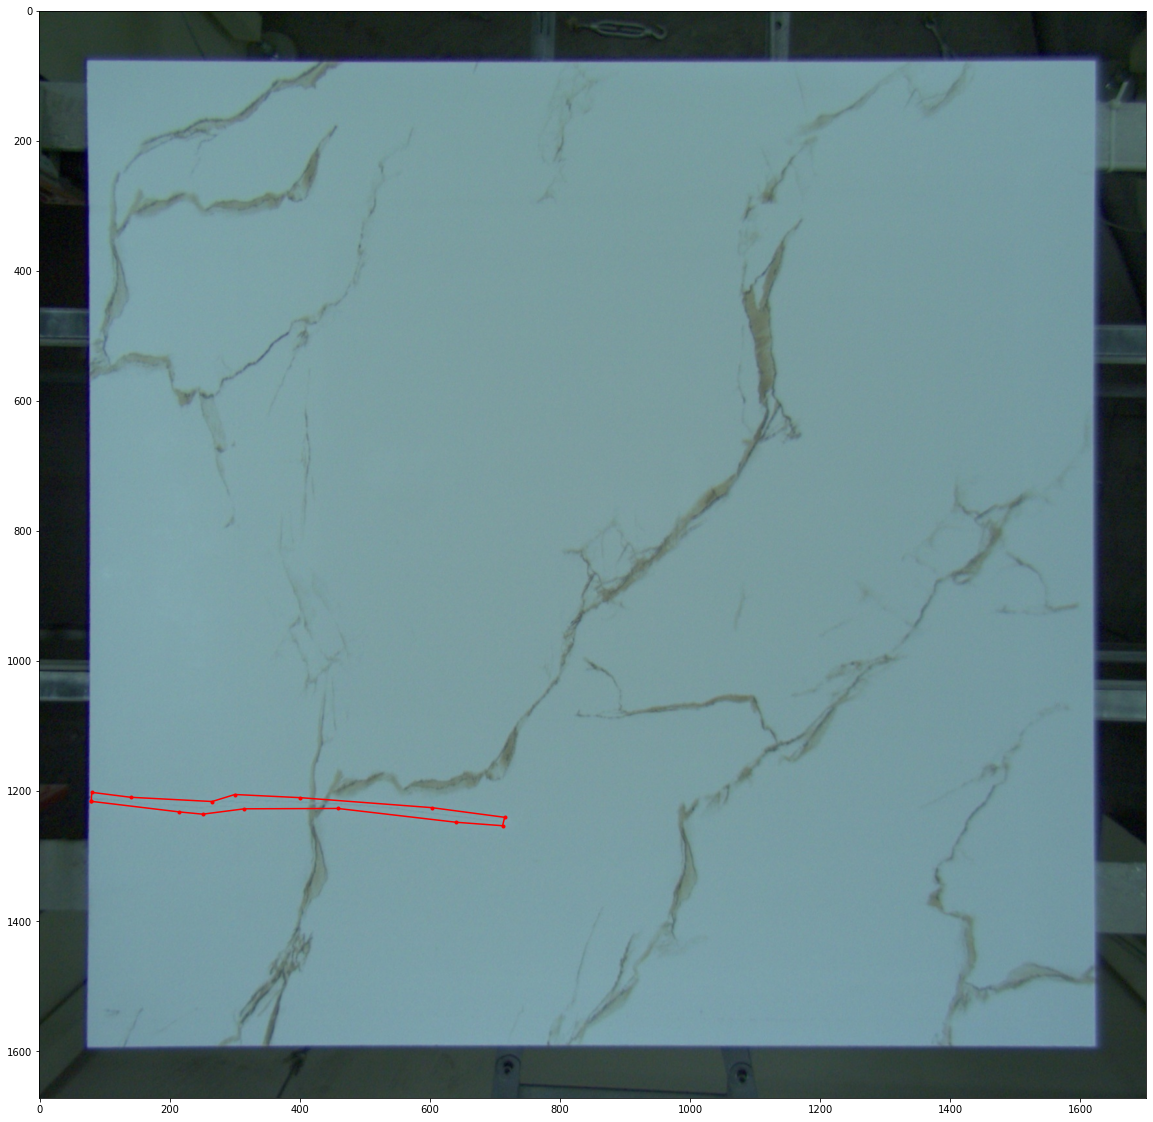

In [ ]:
img = cv.imread(img_name)

f = open(json_name, encoding="utf8")
data = json.load(f)
f.close()

plt.figure(figsize=(20, 20))
plt.imshow(img[..., ::-1])

for shape in data["shapes"]:
  points = np.array(shape['points'])
  ind = list(np.arange(points.shape[0])) + [0]
  plt.plot(points[ind, 0], points[ind, 1], 'r.-')
  # plt.plot(points[-1:-3:-1, 0], points[-1:-3:-1, 1], 'r')

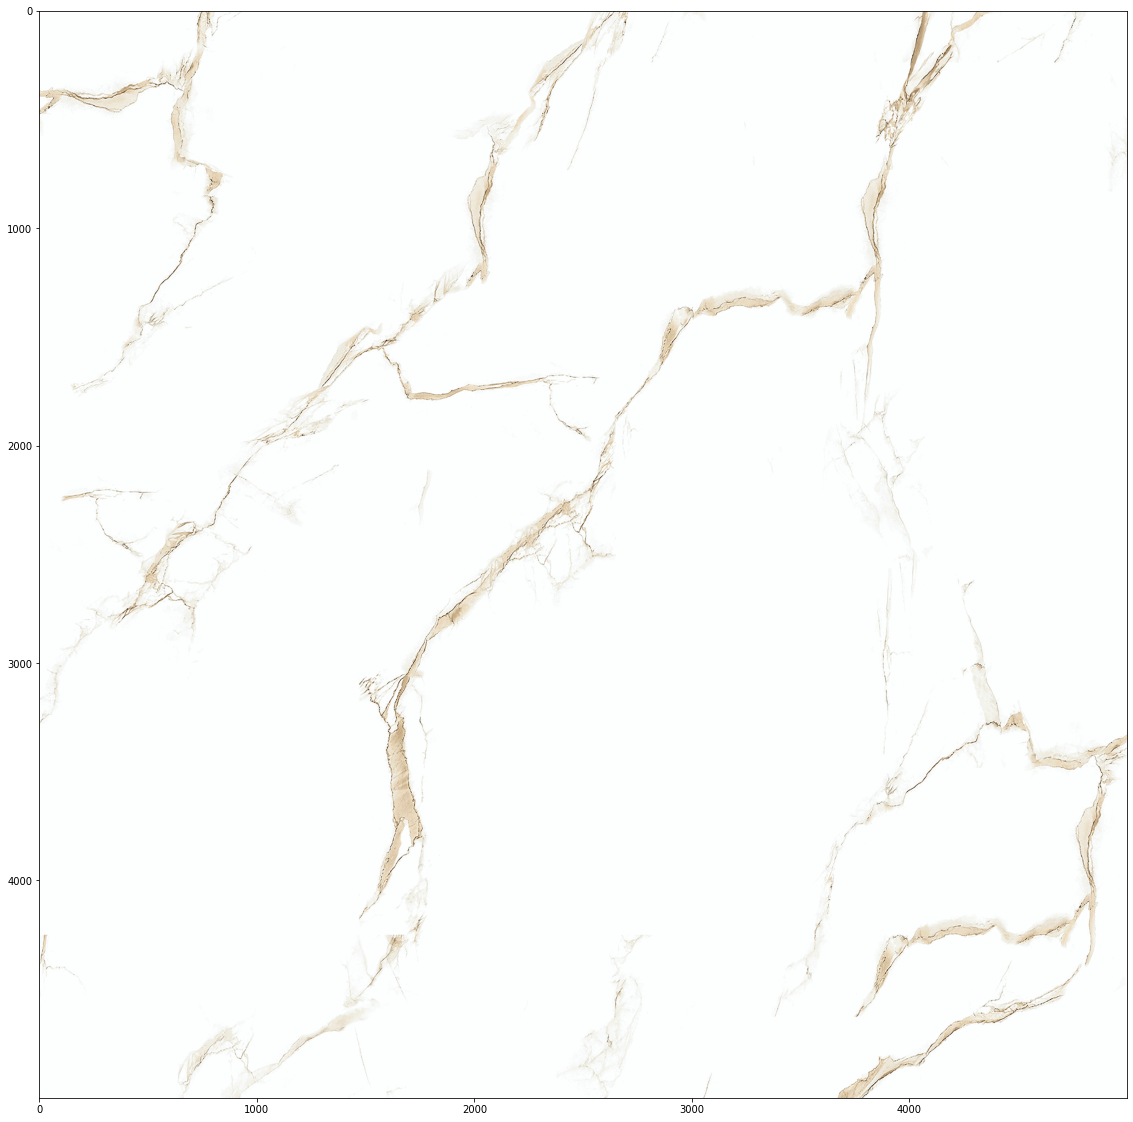

In [ ]:
pattern = cv.imread('/content/Patterns/' + data['pattern'])

plt.figure(figsize=(20, 20))
plt.imshow(pattern[..., ::-1])